In [123]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
df = pd.read_csv("Foods_tagged.csv")

In [30]:
coverage_threshold = 0.8
nutrient_coverage = {}

# create a specific list of nutrient columns
nutrient_cols = [col for col in df.columns if any(unit in col for unit in ['(G)', '(MG)', '(UG)', '(KCAL)'])]

# loop through the list of nutrient columns
for col in nutrient_cols:
    percent_complete = 1 - (df[col].isna().sum() / len(df))   # Divide the number of missing values in that column and divide it by the length of the df, subtract that by one to make percentage
    if percent_complete >= coverage_threshold:   # Keep only the nutrients with greater than or equal to the threshold (80%)
        nutrient_coverage[col] = percent_complete  # Store those nutrients in a dictionary called 'nutrient_coverage'

# Print the number of nutrients with greater than 80% coverage
print(f"Nutrients with >{coverage_threshold*100}% coverage: {len(nutrient_coverage)}")

# Print the top nutrients by coverage
print("\nTop nutrients by coverage:")
for col, percent in sorted(nutrient_coverage.items(), key=lambda x: x[1], reverse=True)[:15]:
    print(f"  {col}: {percent:.1%}")

Nutrients with >80.0% coverage: 65

Top nutrients by coverage:
  Carbohydrate, by difference (G): 100.0%
  Calcium, Ca (MG): 100.0%
  Iron, Fe (MG): 100.0%
  Protein (G): 100.0%
  Total lipid (fat) (G): 100.0%
  Energy (KCAL): 100.0%
  Sodium, Na (MG): 100.0%
  Total Fat (G): 100.0%
  Fiber, total dietary (G): 99.5%
  Water (G): 99.5%
  Magnesium, Mg (MG): 98.5%
  Phosphorus, P (MG): 98.5%
  Thiamin (MG): 98.5%
  Riboflavin (MG): 98.5%
  Potassium, K (MG): 98.5%


In [33]:
# Define our core nutrients (the ones with 100% or 99.5% coverage)
core_nutrients = [
    'Protein (G)',
    'Total lipid (fat) (G)',
    'Carbohydrate, by difference (G)',
    'Energy (KCAL)',
    'Fiber, total dietary (G)',
    'Calcium, Ca (MG)',
    'Iron, Fe (MG)',
    'Sodium, Na (MG)',
    'Magnesium, Mg (MG)',
    'Phosphorus, P (MG)',
    'Potassium, K (MG)'
]

# Create a new working df with only the core nutrients
df_working = df.copy()
for col in core_nutrients:
    df_working = df_working[df_working[col].notna()]

In [35]:
# Put the foods into specific categories based on protein-type
def categorize_protein(row):
    """Fixed version - checks specific foods first"""
    desc = str(row['description']).lower()
    cat = str(row['foodCategory']).lower()
    text = desc + ' ' + cat

    # Dairy products
    if any(word in text for word in ['cheese', 'yogurt', 'milk', 'cream', 'dairy', 'whey', 'casein']):
        return 'Animal-Dairy'

    # Chicken/poultry
    if any(word in text for word in ['chicken', 'poultry', 'turkey', 'duck']):
        return 'Animal-Poultry'

    # Beef
    if any(word in text for word in ['beef', 'steak', 'ground beef', 'chuck', 'sirloin', 'brisket']):
        return 'Animal-Beef'

    # Fish/seafood
    if any(word in text for word in
           ['fish', 'salmon', 'tuna', 'cod', 'tilapia', 'seafood', 'shrimp', 'crab', 'lobster']):
        return 'Animal-Fish'

    # Pork
    if any(word in text for word in ['pork', 'bacon', 'ham', 'sausage']):
        return 'Animal-Pork'

    # Eggs
    if 'egg' in text and 'eggplant' not in text:
        return 'Animal-Eggs'


    # PLANT PROTEINS

    # Nuts
    if any(word in text for word in ['peanut', 'almond', 'cashew', 'walnut', 'pecan', 'pistachio', 'hazelnut']):
        return 'Plant-Nuts'

    # Soy products
    if any(word in text for word in ['tofu', 'tempeh', 'edamame', 'soy']):
        return 'Plant-Soy'

    # Legumes (beans, lentils)
    if any(word in text for word in
           ['bean', 'lentil', 'chickpea', 'legume', 'pinto', 'kidney', 'black bean', 'navy bean']):
        return 'Plant-Legumes'

    # Seeds
    if any(word in text for word in ['seed', 'chia', 'hemp', 'flax', 'pumpkin seed', 'sunflower seed']):
        return 'Plant-Seeds'

    # Grains
    if any(word in text for word in
           ['oat', 'quinoa', 'wheat', 'barley', 'rice', 'grain', 'cereal', 'bread', 'pasta', 'flour']):
        return 'Plant-Grains'

    # Fruits and vegetables
    if any(word in text for word in ['fruit', 'apple', 'banana', 'orange', 'berry', 'grape', 'melon']):
        return 'Plant-Fruits'

    if any(word in text for word in ['vegetable', 'carrot', 'broccoli', 'spinach', 'lettuce', 'tomato', 'pepper']):
        return 'Plant-Vegetables'

    return 'Other'

In [37]:
# Add a column for protein category in df
df_working['protein_category'] = df_working.apply(categorize_protein, axis=1)

In [39]:
# Show distribution and calculate percentages
category_counts = df_working['protein_category'].value_counts()

print("\nprotein source distribution with percentages:")
for cat, count in category_counts.items():
    print(f"{cat:25s}: {count:4d} ({count / len(df_working) * 100:5.1f}%)")


protein source distribution with percentages:
Animal-Dairy             : 1144 ( 22.8%)
Plant-Fruits             :  754 ( 15.0%)
Other                    :  702 ( 14.0%)
Plant-Grains             :  494 (  9.8%)
Animal-Poultry           :  442 (  8.8%)
Plant-Vegetables         :  416 (  8.3%)
Animal-Pork              :  390 (  7.8%)
Plant-Legumes            :  338 (  6.7%)
Animal-Fish              :  104 (  2.1%)
Animal-Beef              :   78 (  1.6%)
Plant-Nuts               :   52 (  1.0%)
Plant-Seeds              :   52 (  1.0%)
Animal-Eggs              :   52 (  1.0%)


In [41]:
# Filter for high-protein foods (≥10g per 100g)
df_protein = df_working[df_working['Protein (G)'] >= 10].copy()

print(f"\nhigh protein foods (≥10g/100g):")
print(f"Total high-protein foods: {len(df_protein)}")
print(f"Percentage of dataset: {len(df_protein)/len(df_working)*100:.1f}%")


high protein foods (≥10g/100g):
Total high-protein foods: 2184
Percentage of dataset: 43.5%


In [87]:
# Calculate some metrics 
# 1. Protein efficiency (protein per calorie)
df_protein['protein_per_calorie'] = df_protein['Protein (G)'] / df_protein['Energy (KCAL)']

# 2. Protein as % of total calories
df_protein['protein_pct_calories'] = (df_protein['Protein (G)'] * 4 / df_protein['Energy (KCAL)']) * 100

# 3. Fat to protein ratio (lower = leaner)
df_protein['fat_to_protein_ratio'] = df_protein['Total lipid (fat) (G)'] / df_protein['Protein (G)']

# 4. Carb to protein ratio
df_protein['carb_to_protein_ratio'] = df_protein['Carbohydrate, by difference (G)'] / df_protein['Protein (G)']

# 5. Nutrient density score 
df_protein['nutrient_density'] = (
    (df_protein['Protein (G)'] / 50) * 0.4 +  # 40% weight on protein
    (df_protein['Fiber, total dietary (G)'].fillna(0) / 25) * 0.2 +  # 20% on fiber
    (df_protein['Iron, Fe (MG)'] / 18) * 0.2 +  # 20% on iron
    (df_protein['Calcium, Ca (MG)'] / 1000) * 0.2  # 20% on calcium
)

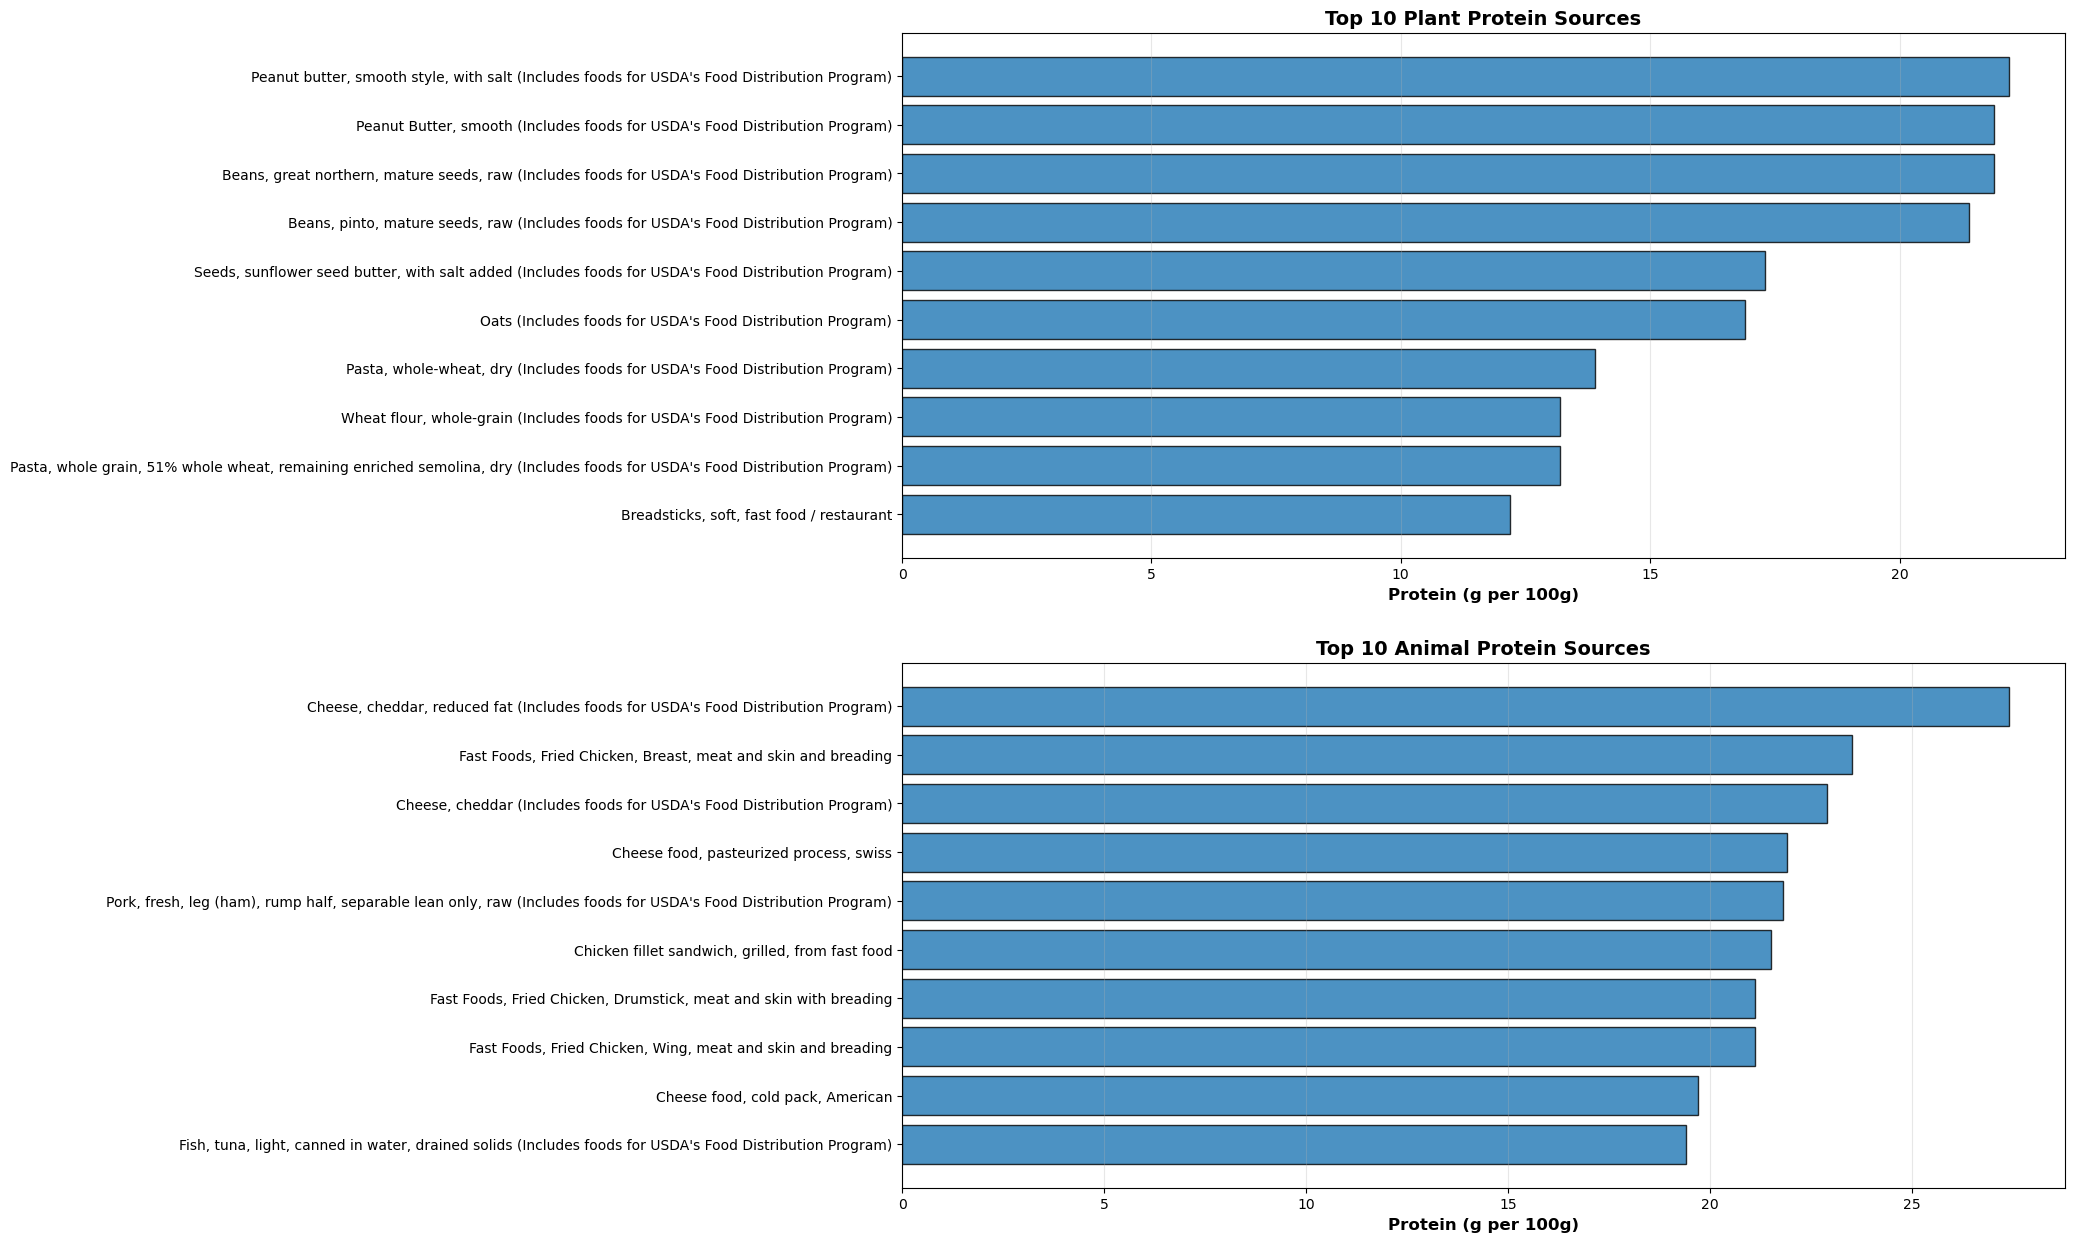

In [147]:
# Get data
plant_foods = df_protein[df_protein['protein_category'].str.contains('Plant')]
top_10_plants = plant_foods.nlargest(10, 'Protein (G)')

animal_foods = df_protein[df_protein['protein_category'].str.contains('Animal')]
top_10_animals = animal_foods.nlargest(10, 'Protein (G)')

# Create horizontal bar chart
fig, ax = plt.subplots(2,1, figsize=(15,15))

ax[0].barh(range(len(top_10_plants)), top_10_plants['Protein (G)'], alpha=0.8, edgecolor='black', linewidth=1)
ax[1].barh(range(len(top_10_animals)), top_10_animals['Protein (G)'], alpha=0.8, edgecolor='black', linewidth=1)

# Labels
ax[0].set_yticks(range(len(top_10_plants)))
ax[0].set_yticklabels(top_10_plants['description'], fontsize=10)
ax[0].set_xlabel('Protein (g per 100g)', fontsize=12, fontweight='bold')
ax[0].set_title('Top 10 Plant Protein Sources', fontsize=14, fontweight='bold')
ax[0].grid(axis='x', alpha=0.3)
ax[0].invert_yaxis()  # Highest at top

# Labels
ax[1].set_yticks(range(len(top_10_animals)))
ax[1].set_yticklabels(top_10_animals['description'], fontsize=10)
ax[1].set_xlabel('Protein (g per 100g)', fontsize=12, fontweight='bold')
ax[1].set_title('Top 10 Animal Protein Sources', fontsize=14, fontweight='bold')
ax[1].grid(axis='x', alpha=0.3)
ax[1].invert_yaxis()  # Highest at top

plt.show()

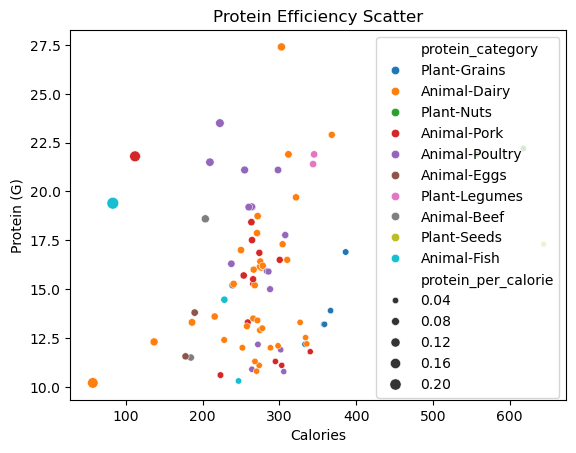

In [141]:
sns.scatterplot(data=df_protein, x='Calories', y='Protein (G)', hue='protein_category', size='protein_per_calorie')
plt.title('Protein Efficiency Scatter')
plt.show()

In [173]:
print(df_protein['protein_category'].unique())

['Plant-Grains' 'Animal-Dairy' 'Plant-Nuts' 'Animal-Pork' 'Animal-Poultry'
 'Animal-Eggs' 'Plant-Legumes' 'Animal-Beef' 'Plant-Seeds' 'Animal-Fish']


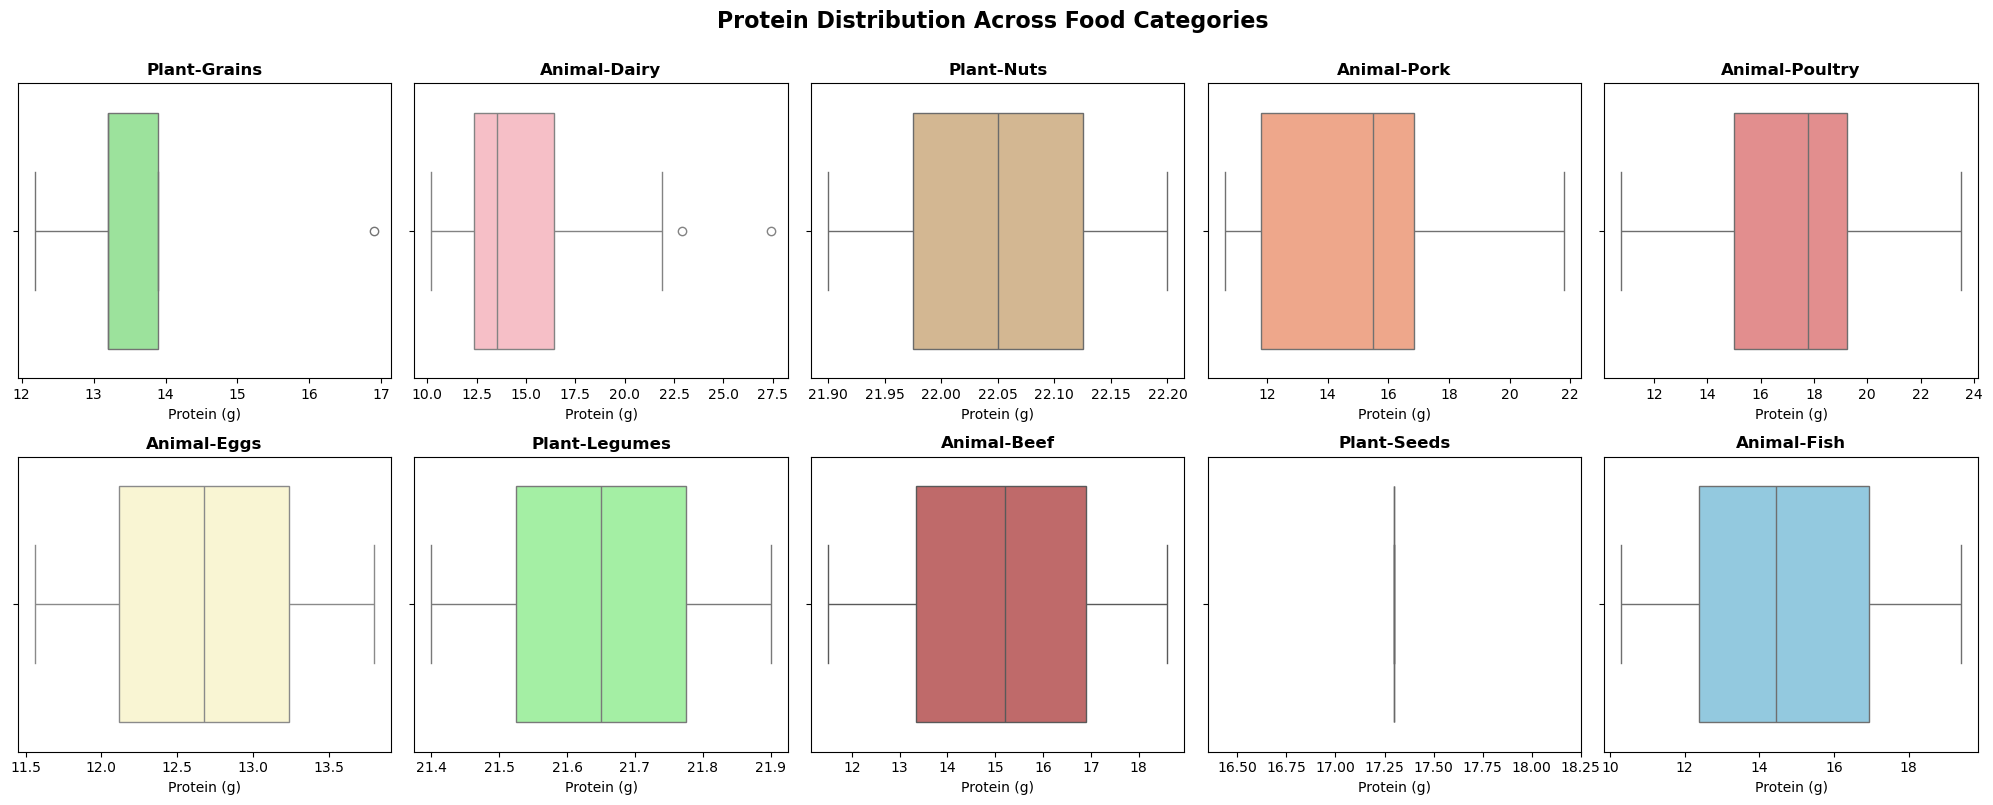

In [181]:
# Filter by category
plant_grains = df_protein[df_protein['protein_category'] == 'Plant-Grains']
animal_dairy = df_protein[df_protein['protein_category'] == 'Animal-Dairy']
plant_nuts = df_protein[df_protein['protein_category'] == 'Plant-Nuts']
animal_pork = df_protein[df_protein['protein_category'] == 'Animal-Pork']
animal_poultry = df_protein[df_protein['protein_category'] == 'Animal-Poultry'] 
animal_eggs = df_protein[df_protein['protein_category'] == 'Animal-Eggs']
plant_legumes = df_protein[df_protein['protein_category'] == 'Plant-Legumes']
animal_beef = df_protein[df_protein['protein_category'] == 'Animal-Beef']
plant_seeds = df_protein[df_protein['protein_category'] == 'Plant-Seeds']
animal_fish = df_protein[df_protein['protein_category'] == 'Animal-Fish']

# Create figure with 2 rows, 5 columns
fig, axes = plt.subplots(2, 5, figsize=(20, 8))

# Row 0 (top row)
sns.boxplot(x=plant_grains['Protein (G)'], ax=axes[0, 0], color='#90EE90')
axes[0, 0].set_title("Plant-Grains", fontweight='bold')
axes[0, 0].set_xlabel("Protein (g)")

sns.boxplot(x=animal_dairy['Protein (G)'], ax=axes[0, 1], color='#FFB6C1')
axes[0, 1].set_title("Animal-Dairy", fontweight='bold')
axes[0, 1].set_xlabel("Protein (g)")

sns.boxplot(x=plant_nuts['Protein (G)'], ax=axes[0, 2], color='#DEB887')
axes[0, 2].set_title("Plant-Nuts", fontweight='bold')
axes[0, 2].set_xlabel("Protein (g)")

sns.boxplot(x=animal_pork['Protein (G)'], ax=axes[0, 3], color='#FFA07A')
axes[0, 3].set_title("Animal-Pork", fontweight='bold')
axes[0, 3].set_xlabel("Protein (g)")

sns.boxplot(x=animal_poultry['Protein (G)'], ax=axes[0, 4], color='#F08080')
axes[0, 4].set_title("Animal-Poultry", fontweight='bold')
axes[0, 4].set_xlabel("Protein (g)")

# Row 1 (bottom row)
sns.boxplot(x=animal_eggs['Protein (G)'], ax=axes[1, 0], color='#FFFACD')
axes[1, 0].set_title("Animal-Eggs", fontweight='bold')
axes[1, 0].set_xlabel("Protein (g)")

sns.boxplot(x=plant_legumes['Protein (G)'], ax=axes[1, 1], color='#98FB98')
axes[1, 1].set_title("Plant-Legumes", fontweight='bold')
axes[1, 1].set_xlabel("Protein (g)")

sns.boxplot(x=animal_beef['Protein (G)'], ax=axes[1, 2], color='#CD5C5C')
axes[1, 2].set_title("Animal-Beef", fontweight='bold')
axes[1, 2].set_xlabel("Protein (g)")

sns.boxplot(x=plant_seeds['Protein (G)'], ax=axes[1, 3], color='#D2B48C')
axes[1, 3].set_title("Plant-Seeds", fontweight='bold')
axes[1, 3].set_xlabel("Protein (g)")

sns.boxplot(x=animal_fish['Protein (G)'], ax=axes[1, 4], color='#87CEEB')
axes[1, 4].set_title("Animal-Fish", fontweight='bold')
axes[1, 4].set_xlabel("Protein (g)")

# Overall styling
plt.suptitle('Protein Distribution Across Food Categories', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('protein_boxplots_by_category.png', dpi=300, bbox_inches='tight')
plt.show()

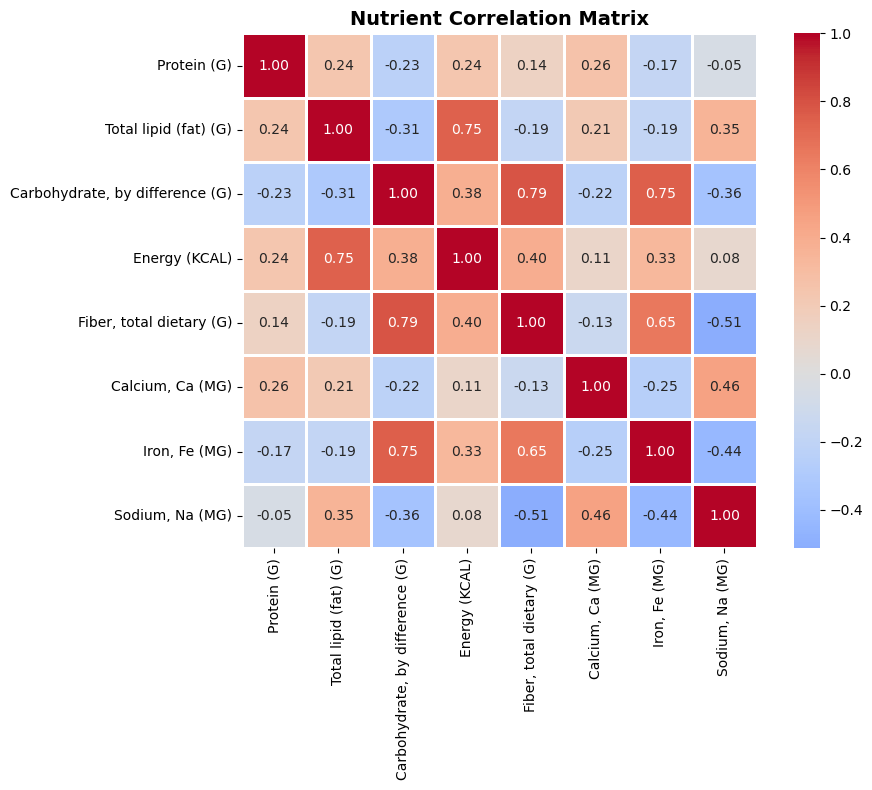

In [186]:
nutrient_cols = [
    'Protein (G)', 'Total lipid (fat) (G)', 'Carbohydrate, by difference (G)',
    'Energy (KCAL)', 'Fiber, total dietary (G)', 'Calcium, Ca (MG)', 
    'Iron, Fe (MG)', 'Sodium, Na (MG)'
]

# Calculate correlation matrix
corr_matrix = df_protein[nutrient_cols].corr()

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, fmt='.2f')
plt.title('Nutrient Correlation Matrix', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.show()